In [1]:
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins, utils

import pprint
import csv
import numpy as np
import pandas as pd
import pickle
import glob
import csv
import base64
import ast
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size':20})

param_order = ["batch_size", "num_epochs", "freeze_layers", "subsample_dataset", "convnet"]
%matplotlib inline

#mpld3 hack
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        import numpy as np
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
from mpld3 import _display
_display.NumpyEncoder = NumpyEncoder

### Read data

In [2]:
BASE_DIR = "./data/sweep/sweep2/"
gpu_data = pd.read_csv(BASE_DIR + "node_gpu_0.csv", header=None, names=["timestamp", "id", "load", "memoryTotal", "memoryUsed"])

In [3]:
def get_config_from_modelid(model_id):
    params = model_id.split(',')
    assert len(params) == len(param_order)
    param_dict = dict(zip(param_order, params))
    return param_dict

def read_accuracy_file(path):
    with open(path) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        first_line = next(csvreader)
        return first_line

def read_train_time(model_id, attribute="totaltime"):
    file_path = BASE_DIR + model_id + "_train_times.csv"
    train_profile = pd.read_csv(file_path, header=None, names=["timestamp", "totaltime", "beforetask", "traintask", "aftertask"])
    time_of_interest = train_profile[attribute].mean()
    end_time = train_profile["timestamp"][0] - train_profile["aftertask"][0]
    start_time = train_profile["timestamp"][0] - train_profile["totaltime"][0]
    return start_time, end_time, time_of_interest

def get_gpu_mean(start_time, end_time, attribute="memoryUsed"):
    gpu_data_of_interest = gpu_data[(gpu_data["timestamp"] > start_time) & (gpu_data["timestamp"] < end_time)]
    memutil = gpu_data_of_interest[attribute].mean()
    return memutil

def parseval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return s

In [4]:
# Get list of configurations
list_of_files=glob.glob(BASE_DIR + "*_test_accuracy.csv")
sweep_data = []
config_strs = []
for path in list_of_files:
    model_id = path.split('/')[-1].split('_')[0]
    config = get_config_from_modelid(model_id)
    config_strs.append(pprint.pformat(config))
    raw_acc_data = read_accuracy_file(path)
    acc_data = ast.literal_eval(raw_acc_data[1])
    test_acc = acc_data["total"]
    start_time, end_time, train_time = read_train_time(model_id, attribute="totaltime")
    mean_mem_util = get_gpu_mean(start_time, end_time, "memoryUsed")
    mean_gpu_util = get_gpu_mean(start_time, end_time, "load")
    
    sweep_data.append([model_id, test_acc, train_time, start_time, end_time, mean_mem_util, mean_gpu_util,
                      *[parseval(config[p]) for p in param_order]])

sweep_data = pd.DataFrame(sweep_data ,columns=['model_id', 'test_acc', 'train_time', 'start_time', 'end_time', 'mean_mem_util', 'mean_gpu_util',
                                              *param_order])

### Plotting

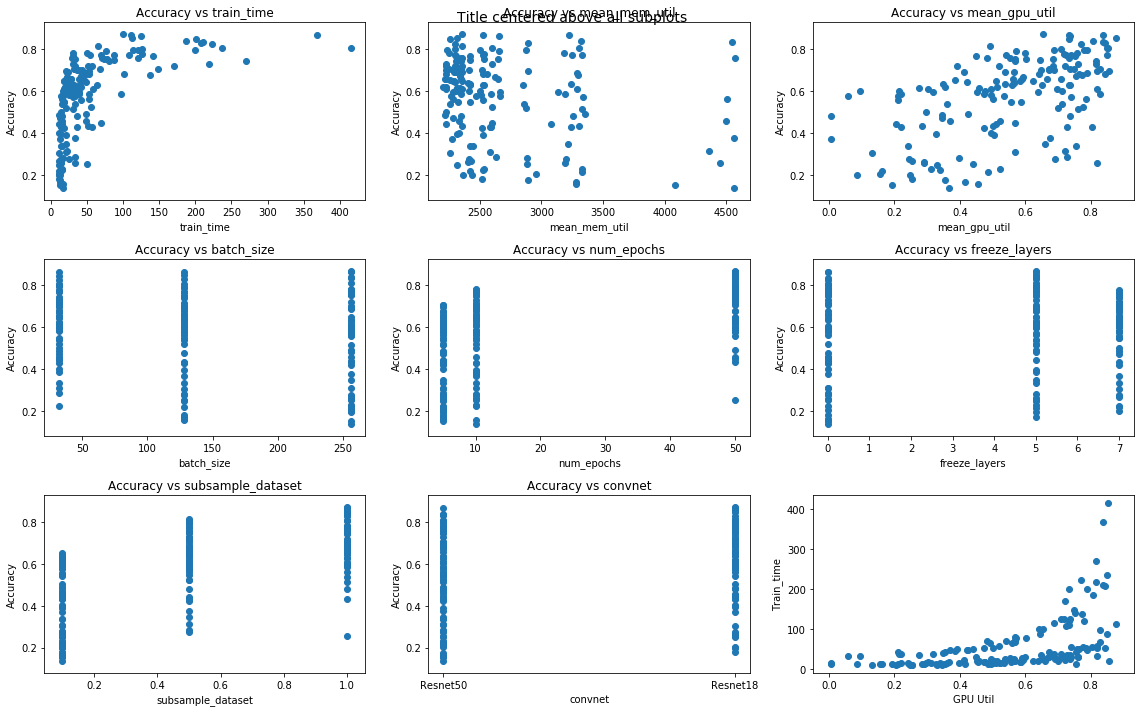

In [5]:
plot_params = ["train_time", "mean_mem_util", "mean_gpu_util", "batch_size", "num_epochs", "freeze_layers", "subsample_dataset", "convnet"]

fig, axs = plt.subplots(3,3,figsize=(16,10))

for idx, ax in enumerate(axs.reshape(-1)):
    if idx > len(plot_params) - 1:
        break
    attr = plot_params[idx]
    scat_plot = ax.scatter(sweep_data[attr], sweep_data['test_acc'])
    ax.set_xlabel(attr)
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs {}'.format(attr))
    if attr=='convnet':
        ax.set_xticks([0.0,1.0])
        ax.set_xticklabels(["Resnet50", "Resnet18"])
    labels = config_strs
    tooltip = mpld3.plugins.PointLabelTooltip(scat_plot, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

axs[2,2].scatter(x=sweep_data["mean_gpu_util"], y=sweep_data["train_time"])
axs[2,2].set_ylabel("Train_time")
axs[2,2].set_xlabel("GPU Util")

plt.tight_layout()
fig.suptitle("Title centered above all subplots", fontsize=14)
mpld3.plugins.connect(fig, plugins.LinkedBrush(scat_plot))
mpld3.save_html(fig, "icarl_sweep.html")

## Independent Analysis Toolkit

In [77]:
from ipywidgets import interactive
%matplotlib inline

plot_options = ["test_acc", "train_time", "mean_mem_util", "mean_gpu_util", "batch_size", "num_epochs", "freeze_layers", "subsample_dataset", "convnet"]


def plot_interactive(x,y):
    plt.scatter(sweep_data[x], sweep_data[y])
    plt.title("{} vs {}".format(x,y))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

interactive_plot = interactive(plot_interactive, x=plot_options, y=plot_options)
interactive_plot

interactive(children=(Dropdown(description='x', options=('test_acc', 'train_time', 'mean_mem_util', 'mean_gpu_…

In [84]:
args = ["batch_size", "num_epochs", "freeze_layers", "subsample_dataset", "convnet"]

search_space = {
    "batch_size": [32, 128, 256],
    "num_epochs": [5, 10, 50],
    "freeze_layers": [0, 5, 7],
    "subsample_dataset": [1, 0.5, 0.1],
    "convnet": ["resnet50", "resnet18"]
}

for val in search_space.values():
    val.append(None)

def plot_interactive_fixedvals(x, y, **kwargs):
    col_match = [(col,col_val) for col, col_val in kwargs.items() if col_val is not None]
    idxs_list = [sweep_data[col] == col_val for col, col_val in col_match]
    idxs = np.logical_and.reduce(idxs_list)
    if type(idxs) == np.bool_:
        idxs = sweep_data == sweep_data 
    #print(idxs)
    data = sweep_data[idxs]
    data_x = data[x]
    data_y = data[y]
    
    plt.figure(figsize=(6,6), dpi=125)
    plt.scatter(data_x, data_y)
    for index, row in data.iterrows():
        plt.text(row[x], row[y], str(row['model_id']), size=7)
    plt.title("{} vs {}".format(x,y))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

interactive_plot = interactive(plot_interactive_fixedvals, x=plot_options, y=plot_options,
                              **{arg: search_space[arg] for arg in args})
interactive_plot

interactive(children=(Dropdown(description='x', options=('test_acc', 'train_time', 'mean_mem_util', 'mean_gpu_…

### Old stuff

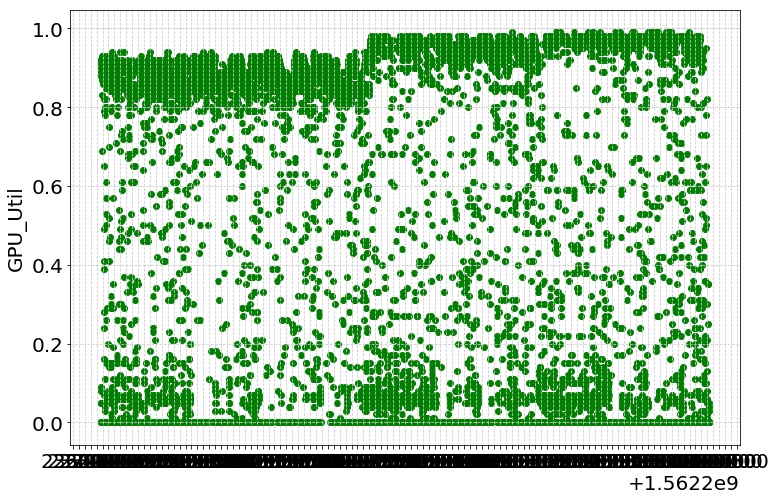

In [212]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(gpu_data["timestamp"], gpu_data["load"], color='g')
# for c, c_data in infer_accuracy_per_class.items():
#     ax1.plot(infer_timestamps, c_data, marker='*')
ax1.set_ylabel('GPU_Util')

ax2 = ax1.twinx()
ax2.plot(infer_timestamps, infer_latency_data, 'r-', marker='o')
ax2.set_ylabel('per sample infer_latency (ms)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

ax1.set_xlabel("Wall time")

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Accuracy'),
                   Line2D([0], [0], color='r', lw=4, label='Infer latency'),
                   Line2D([0], [0], marker='o', color='w', label='GPU CoreUtil',
                          markerfacecolor='g', markersize=15)]

# Create the figure
ax1.legend(handles=legend_elements, loc='lower right', prop={'size': 12})


ax1.xaxis.set_major_locator(MultipleLocator(100))
# Change minor ticks to show every 5. (50/5 = 10)
ax1.xaxis.set_minor_locator(AutoMinorLocator(1))
ax1.yaxis.set_minor_locator(AutoMinorLocator(1))

# Turn grid on for both major and minor ticks
ax1.grid(which='major', color='#CCCCCC', linestyle='--')
ax1.grid(which='minor', color='#CCCCCC', linestyle=':')

In [148]:
# Computing mean latency between stamps:
time_ranges = {
    'all_layers': [100, 290],
    '7_frozen': [340, 480]
}
time_ranges = {
    'all_layers': [500, 1900],
    '7_frozen': [2250, 3100]
}
time_ranges = {
    'all_layers': [100, 400],
    '7_frozen': [570, 800]
}
time_ranges = {
    'all_layers': [100, 400],
    '7_frozen': [475, 650],
    '6_frozen': [750, 950],
    '5_frozen': [1075, 1300]
}
mean_latency = {}
mean_core_util = {}
mean_mem_util = {}

In [149]:
for name, [start_time, end_time] in time_ranges.items():
    data_of_interest = data[(data["timestamp"] > start_time) & (data["timestamp"] < end_time)]
    lat = (data_of_interest["latency"]/data_of_interest["samples"]).mean()
    
    gpu_data_of_interest = gpu_data[(gpu_data["timestamp"] > start_time) & (gpu_data["timestamp"] < end_time)]
    coreutil = gpu_data_of_interest["load"].mean()
    memutil = gpu_data_of_interest["memoryUsed"].mean()
    
    mean_latency[name] = lat
    mean_core_util[name] = coreutil
    mean_mem_util[name] = memutil

In [150]:
print(mean_latency)
print(mean_core_util)
print(mean_mem_util)

{'all_layers': 0.000689873078736392, '7_frozen': 0.0006720954427352319, '6_frozen': 0.000661435899734497, '5_frozen': 0.0006613078650306252}
{'all_layers': 0.9581355932203399, '7_frozen': 0.924360465116279, '6_frozen': 0.937857142857143, '5_frozen': 0.9472072072072065}
{'all_layers': 5479.0, '7_frozen': 4641.0, '6_frozen': 4809.0, '5_frozen': 5081.0}


In [151]:
def plot_dict(D):
    plt.figure()
    plt.bar(range(len(D)), list(D.values()), align='center', width=0.5)
    plt.xticks(range(len(D)), list(D.keys()))

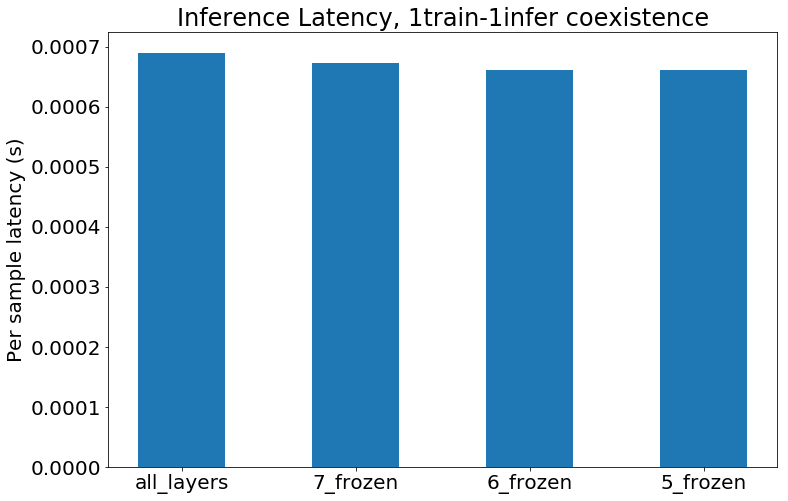

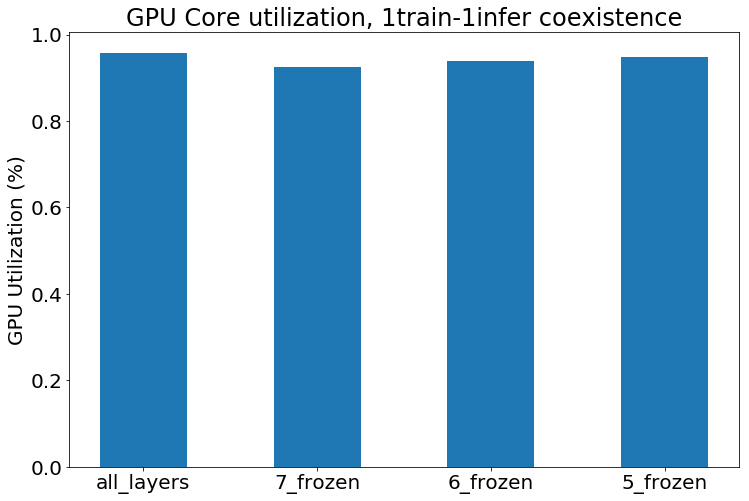

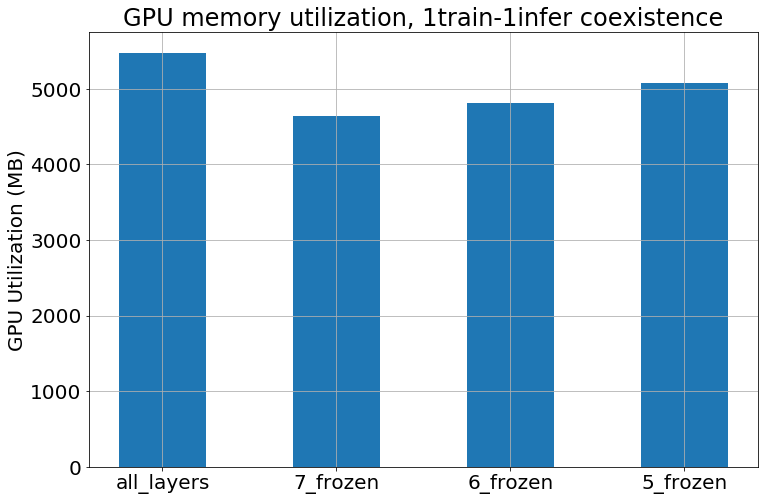

In [153]:
plot_dict(mean_latency)
plt.title("Inference Latency, 1train-1infer coexistence")
plt.ylabel("Per sample latency (s)")

plot_dict(mean_core_util)
plt.title("GPU Core utilization, 1train-1infer coexistence")
plt.ylabel("GPU Utilization (%)")

plot_dict(mean_mem_util)
plt.title("GPU memory utilization, 1train-1infer coexistence")
plt.ylabel("GPU Utilization (MB)")
plt.grid()

['./data/layer_ablation_single_765frozen/2_train_epochstats.csv', './data/layer_ablation_single_765frozen/4_train_epochstats.csv', './data/layer_ablation_single_765frozen/5_train_epochstats.csv', './data/layer_ablation_single_765frozen/3_train_epochstats.csv']


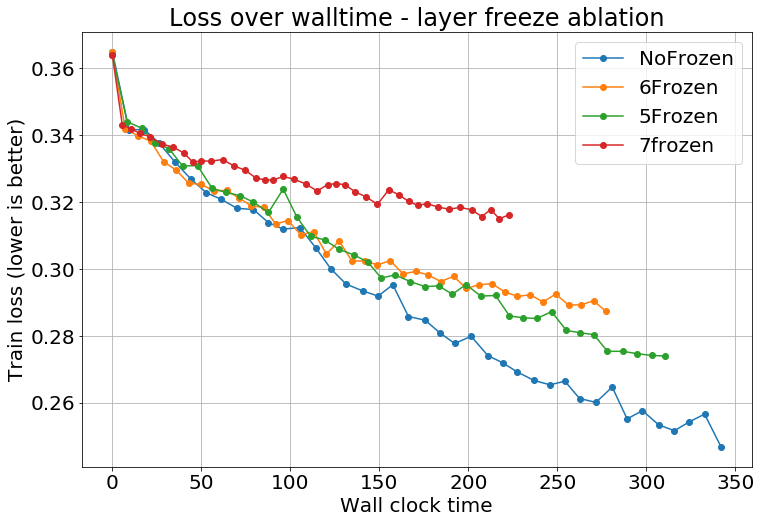

In [154]:
# AUC
train_data_files = glob.glob(BASE_DIR + "*_train_epochstats.csv")

label_map = {
    "1": "Infer",
    "2": "Infer",
    "3": "Infer",
    "4": "No_frozen",
    "5": "No_frozen",
    "6": "No_frozen",
    "7": "7layers_frozen",
    "8": "7layers_frozen",
    "9": "7layers_frozen"
}

label_map = {
    "1": "Infer",
    "2": "NoFrozen",
    "3": "7frozen",
    "4": "6Frozen",
    "5": "5Frozen",
    "6": "No_frozen",
    "7": "7layers_frozen",
    "8": "7layers_frozen",
    "9": "7layers_frozen"
}

print(train_data_files)
for path in train_data_files:
    idx = path.split("/")[-1].split("_")[0]
    train_data = pd.read_csv(path, header=None, names=["timestamp", "epochtime", "loss"])
    train_data["timestamp"] = train_data["timestamp"] - min(train_data["timestamp"])
    plt.plot(train_data["timestamp"], train_data["loss"], label=label_map[idx], marker='o')

plt.xlabel("Wall clock time")
plt.ylabel("Train loss (lower is better)")
plt.title("Loss over walltime - layer freeze ablation")
plt.legend()
plt.grid()

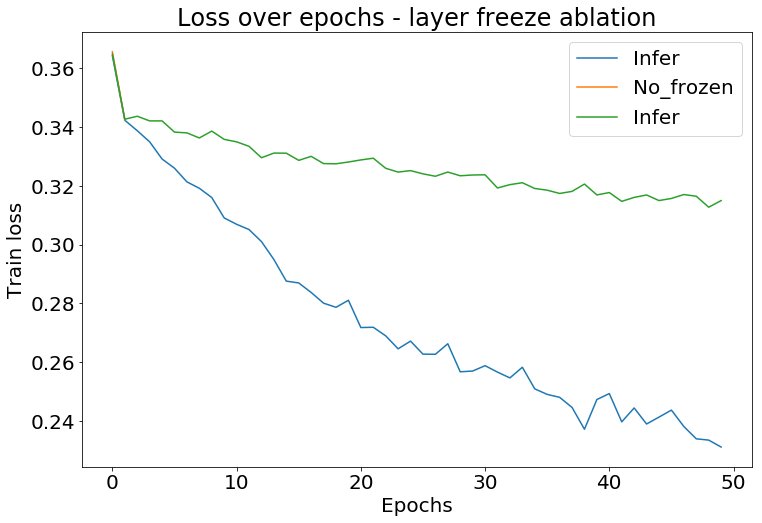

In [129]:
for path in train_data_files:
    idx = path.split("/")[-1].split("_")[0]
    train_data = pd.read_csv(path, header=None, names=["timestamp", "epochtime", "loss"])
    plt.plot(train_data["loss"], label=label_map[idx])

plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.title("Loss over epochs - layer freeze ablation")
plt.legend()

2.3M -> 1.4M params